# Time Series Analysis Notebook

## Return Forecasting: Read Historical Daily CAD/JPY Exchange Rate Data
In this notebook, the historical Dollar-Yen exchange rate futures data will be loaded to further apply time series analysis and modeling to determine whether there is any predictable behavior.

---

### Import the Required Libraries

In [59]:
# Initial imports and dependencies 
import numpy as np
import pandas as pd
import hvplot
import hvplot.pandas
from pathlib import Path
%matplotlib inline

## Return Forecasting

### Reading in the CSV for CAD/JPY Exchange Rates

In [4]:
# Read in the CAD/JPY csv
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)

In [5]:
# Display the dataframe
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [6]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]

In [7]:
# Display the trimmed dataframe
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


---

## Return Forecasting: Initial Time-Series Plotting

The notebook will begin by plotting the "Settle" price to determine if there are any patterns; long term and/or short term. 

In [17]:
# Plot just the "Price" column from the dataframe:
cad_jpy_plot = cad_jpy_df.hvplot.line(title = "CAD/JPY Exchange Rate",
                                      xlabel = "Date",
                                      ylabel = "Price",
                                      y = 'Price',
                                      rot = 45,
                                      color = 'purple',
                                      legend = False).opts(height = 500, width = 1000)
cad_jpy_plot

:Curve   [Date]   (Price)

**Are there any patterns, long term and/or short?**

From the CAD/JPY Exchange Rate plot, it is evident that the trend for the Japanese Yen weakens throughout the long term compared to the Canadian Dollar. It can be noticed there is a common short term trend of ups and downs however, there is a slightly more consistent trend indicating a decreasing trend. 

---

## Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into a trend and noise.

In [18]:
# Import the Hodrick-Prescott Filter
import statsmodels.api as sm

In [19]:
# Apply the Hodrick-Prescott Filter by decomposing the "Price" into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [20]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
# First, create a dataframe with only the exchange rate price
exchange_rate_price_df = pd.DataFrame(cad_jpy_df['Price'])

In [21]:
# Display the new dataframe
exchange_rate_price_df.head()

,Price
Date,
1990-01-02,126.37
1990-01-03,125.30
1990-01-04,123.46
1990-01-05,124.54
1990-01-08,124.27


In [22]:
# Add the two columns; noise and trend

# Noise column
exchange_rate_price_df['noise'] = ts_noise

# Trend column 
exchange_rate_price_df['trend'] = ts_trend 

In [23]:
# Display the df with its new columns; noise and trend
exchange_rate_price_df.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


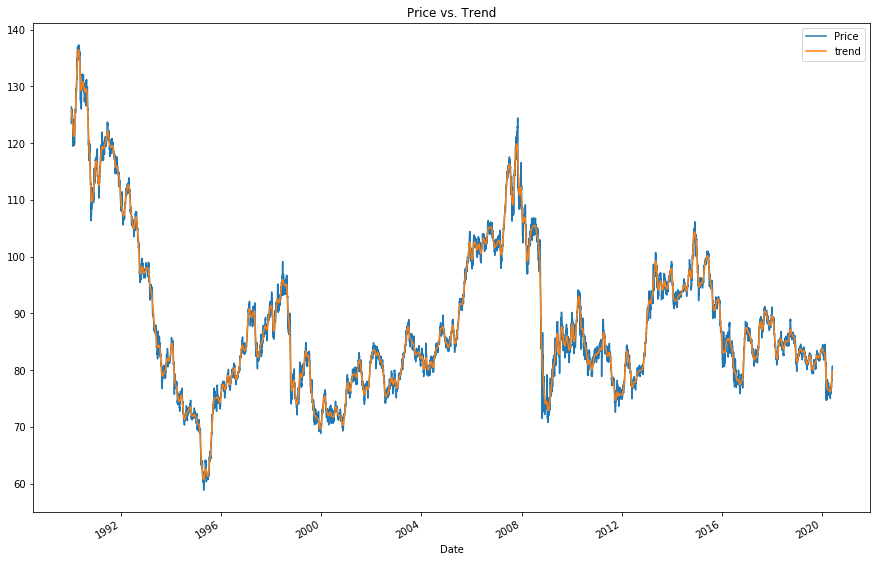

In [24]:
# Plot the exchange rate Price vs. the Trend
price_vs_trend_plot = (exchange_rate_price_df['Price'].plot(figsize = (15,10),
                                                            title = "Price vs. Trend", 
                                                            legend = True),
                       exchange_rate_price_df['trend'].plot(legend = True))

**Present Patterns:**

Plotting the trend against the futures returns throughout the given data period, it is evident that there are many short term. A short term up and down pattern may provide a potnetial profitable trading strategy. Observing the price (blue line), there are various occasions it falls below the trend (orange line). Indicating the Japanese Yen is undervalued during these periods, providing a short term buying opportunity for investors recognizing the pattern. 

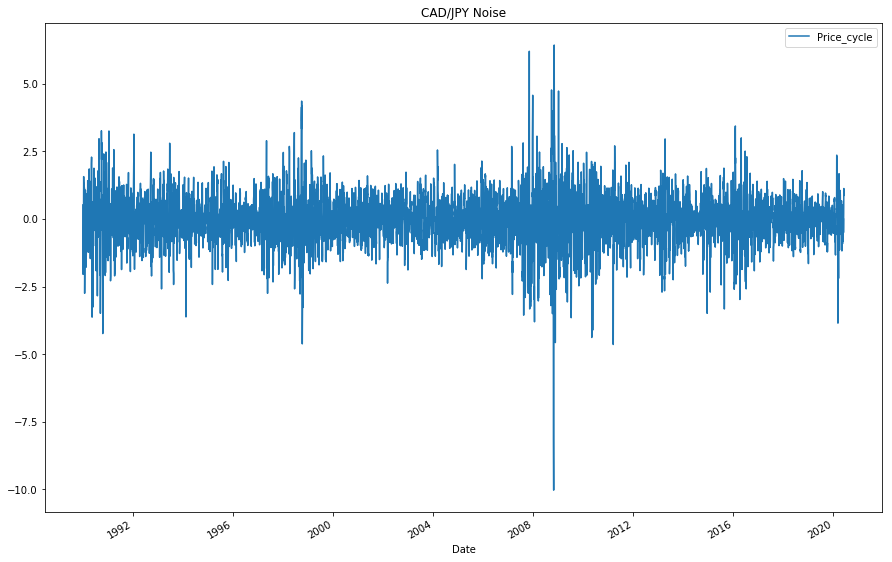

In [25]:
# Plot the price noise
ts_noise_plot = ts_noise.plot(figsize = (15, 10),
                              title = "CAD/JPY Noise", 
                              legend = True)

---

## Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

### Calculating Price Percentage Returns: 

In [26]:
# First, calculate the daily returns using the pct_change function
# (Make sure to multiply the pct_change() results by 100)
returns = (cad_jpy_df[["Price"]].pct_change() * 100)

# Drop the nan's from the table
# In this case, you may have to replace inf, -inf values with np.nan's
returns = returns.replace(-np.inf, np.nan).dropna()

In [27]:
# Display the results
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [28]:
# Import the ARMA statsmodels
from statsmodels.tsa.arima_model import ARMA

In [29]:
# Estimate and ARMA model
# Create the ARMA model using the return values and the order
# Order is (2,1)
model = ARMA(returns.values, order=(2,1))

In [30]:
# Fit the model and assign it to a variable called results
results = model.fit()

In [31]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Mon, 17 Aug 2020   AIC                          19513.955
Time:                        18:32:45   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.031      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1697           +0.0000j           42.1697            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

In [35]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).hvplot.line(title = "5 Day Returns Forecast",
                                                       color = "lightseagreen")

:Curve   [index]   (0)

**Model Forecast:**

The five day returns forecast plot suggest upcoming volitile returns. It may be significant to mention, the forecast trend mmimics the short term ups and downs trend of the CAD/JPY Exchange Rate plot.

**Based on the p-value, is the model a good fit?**

The statistical significance of the p-value in this model suggests the model is not a good fit. The constant *p* = .807 and the autoregressive lag values; *p* < .001 (ar.L1), *p* = .140 (ar.L2) provide strong statistical evidence indicating the the model fails to reject the null hypothesis. Furthermore, despite the first autoregressive lag (ar.L1) *p* < .001, the other two values are above the acceptable threshold (*p* < .05). 

Sources used to answer this question:

https://www.simplypsychology.org/p-value.html#:~:text=How%20do%20you%20know%20if,%E2%89%A4%200.05)%20is%20statistically%20significant.


---

## Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Exchange Rate Price. What does the model forecast will happen to the Japanese Yen in the near term?

### Creating the ARIMA Model:

In [36]:
# Import the ARIMA statsmodels
from statsmodels.tsa.arima_model import ARIMA

In [37]:
# Estimate and ARIMA model
# Create the ARIMA model
# Order is (5, 1, 1)

#In this step when they say "raw exchange rate price" it means from the original df???
model = ARIMA(cad_jpy_df['Price'], order=(5, 1, 1))

/Users/alexdg/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/alexdg/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [38]:
# Fit the model and assign it to a variable called results
results = model.fit()

In [39]:
# Output the ARIMA model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Mon, 17 Aug 2020   AIC                          17507.244
Time:                        18:35:29   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

In [41]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).hvplot.line(title = "5 Day Futures Price Forecast",
                                                       color = "firebrick")

:Curve   [index]   (0)

**Model Forecast:**
**What does the model forecast will happen to the Japanese Yen in the near term?**

In the ARIMA model, the autoregressor is set to 5 with a differencing factor of 1, and a moving average of 1. From this input, the five day futures price forecast indicates a downward sloping trend in the Japanese Yen. 

**Based on the p-value, is this model a good fit?**

In the ARIMA model, the p-value is statistically nonsignificant. The constant *p* = .458 is greater than the 5% threshold (*p* < .05). Three of the five (ar.L2, ar.L3, & ar.L4) autoregressive lag (P = 5) and the one moving average lag (Q = 1) have *p* > .05 output values. Statistical evidence recommends failing to reject the null hypothesis. Therefore, based on the p-values, this model is not a good fit. 

---

## Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

### GARCH Model:

In [42]:
# Import GARCH dependencies to create the model
import arch as arch

In [43]:
# Estimate a GARCH model:
model = arch.arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

In [44]:
# Fit the model using a results variable 
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 569545243.4284524
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838552966728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11769.086094978014
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.350185312931
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.366479560163
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.111921464748
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027336222945
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.02203125968
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021014202204
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020776838068
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764888566
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.02076489123
Optimization terminated successfully    (Exit mode 0)
          

In [45]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Mon, Aug 17 2020   Df Residuals:                     7924
Time:                        18:36:13   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Volatility Patterns & P-Value:**

In the GARCH model and volatility forecast, the p-values are lower than the ones in the ARMA and ARIMA return models above. In this instance, *p* < .05 (except for alpha[2]), thus, indicating a better model performance. 

In [46]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [47]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results.forecast(start='2020-06-04', horizon = forecast_horizon)
forecasts

In [48]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)

In [49]:
# Display the results
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566035,12.573725,12.581308,12.588786,12.596161


In [50]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T

In [51]:
# Display the table
final.head()

Date,2020-06-04
h.1,12.566035
h.2,12.573725
h.3,12.581308
h.4,12.588786
h.5,12.596161


In [57]:
# Plot the final forecast
final.hvplot.line(title = "5 Day Forecast of Volatility",
                  color = "indigo")

:Curve   [index]   (2020-06-04 00:00:00)

**Model Forecast:**

Based on the five day volatility forecast plot, the CAD/JPY volatility is expected to rise over the presented period. An increase in volatility may suggest an unpredicable price change over the short term.

Sources used to answer this question: 

https://www.investopedia.com/terms/v/volatility.asp#:~:text=A%20higher%20volatility%20means%20that,time%20period%20in%20either%20direction

---

# Conclusions

#### Based on your time series analysis, would you buy the yen now?

Based on the performance of the models in the time series analysis, investing in the Japanese Yen would not result in an optimized profit purchasing strategy. The ARMA and ARIMA model evaluations indicate the p-value is nonsignificant (*p* > .05). Although, the GARCH model does provide a better statistical outlook on the p-values (*p* < .05), indicating an imporved performance. However, the predicted volatility forecast suggests a steady increase in the given period. This spike in volatility may suggest a fluctuation in prices therefore, not providing investors a solid underlying trend to focus on if choosing to buy the JPY in the present. Additionally, the ARIMA model predicts a decline in the forecasted price of the Yen. Therefore, based on the given factors, purchasing the Yen right now would require further statistical analysis and financial modelling to ensure the outcome is an optimal investment. 


#### Is the risk of the yen expected to increase or decrease?

Creating an additional volatility forecast model with a greater forecast horizon will assist
in improving the accuracy of this response:

In [58]:
# Create a 50 day forecast of volatility
forecast_horizon = 15

# Start the forecast using the last_day calculated in the GARCH Model section above
forecasts = results.forecast(start='2020-06-04', horizon = forecast_horizon)
forecasts

# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)

# Display the results
intermediate.head()

# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T

# Display the table
final.head()

# Plot the final forecast
final.hvplot.line(title = "15 Day Forecast of Volatility",
                  color = 'crimson')

:Curve   [index]   (2020-06-04 00:00:00)

The JPY volatility forecast is expected to increase throughout a fifteen day time period. The increase in volatility may suggest a short term price fluctuation.

**Based on the model evaluation, would you feel confident in using these models for trading?**

ARMA, ARIMA, and GARCH are solid foundational tools that provide a good model performance evaluation. Given a greater forecast horizon, these three models can yield useful insight in stochastic modelling required for better trading strategies. However, I would not rely solely on these three performance indicators. To imporve a trading strategy a combination of various evaluation models should be considered to ensure an optimal entry and exit point to maximize the return on investment. 